<a href="https://colab.research.google.com/github/alinohans/Emotion-Recognition/blob/main/Emotion_Recognition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
! pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
! kaggle datasets download ejlok1/cremad

 96% 434M/451M [00:06<00:00, 64.5MB/s]
100% 451M/451M [00:06<00:00, 73.2MB/s]


In [17]:
! unzip cremad.zip

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: AudioWAV/1031_IEO_NEU_XX.wav  
  inflating: AudioWAV/1031_IEO_SAD_HI.wav  
  inflating: AudioWAV/1031_IEO_SAD_LO.wav  
  inflating: AudioWAV/1031_IEO_SAD_MD.wav  
  inflating: AudioWAV/103

In [18]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [19]:
Crema = "/content/AudioWAV/"

In [20]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,fear,/content/AudioWAV/1062_ITH_FEA_XX.wav
1,disgust,/content/AudioWAV/1090_WSI_DIS_XX.wav
2,angry,/content/AudioWAV/1073_IEO_ANG_MD.wav
3,disgust,/content/AudioWAV/1067_IWL_DIS_XX.wav
4,fear,/content/AudioWAV/1057_ITS_FEA_XX.wav


In [21]:
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,fear,/content/AudioWAV/1062_ITH_FEA_XX.wav
1,disgust,/content/AudioWAV/1090_WSI_DIS_XX.wav
2,angry,/content/AudioWAV/1073_IEO_ANG_MD.wav
3,disgust,/content/AudioWAV/1067_IWL_DIS_XX.wav
4,fear,/content/AudioWAV/1057_ITS_FEA_XX.wav


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


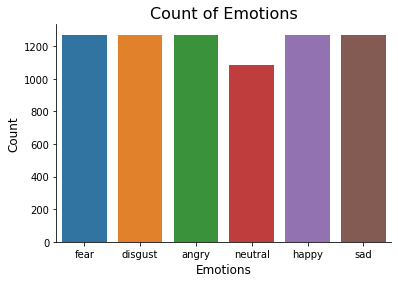

In [22]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [23]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

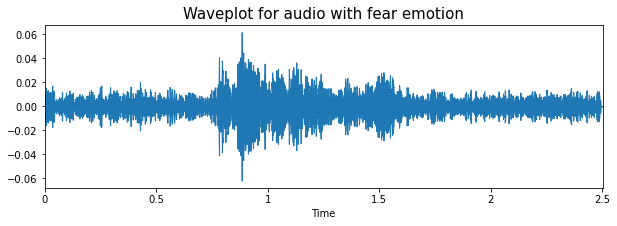

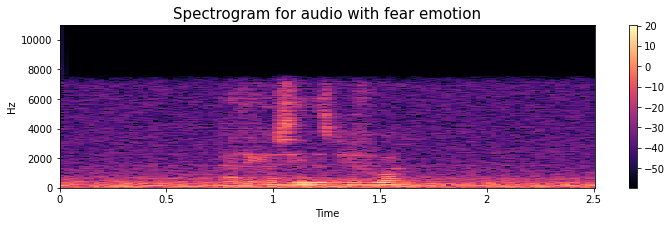

In [24]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

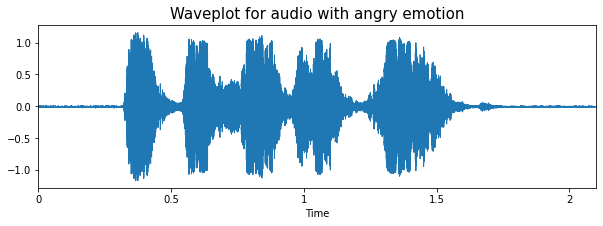

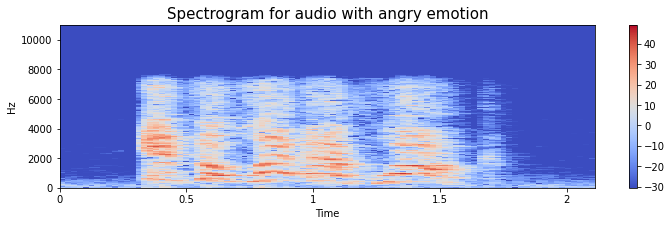

In [25]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

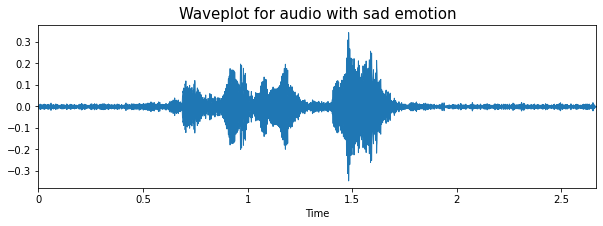

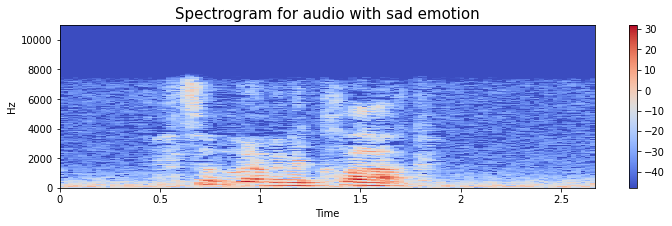

In [26]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

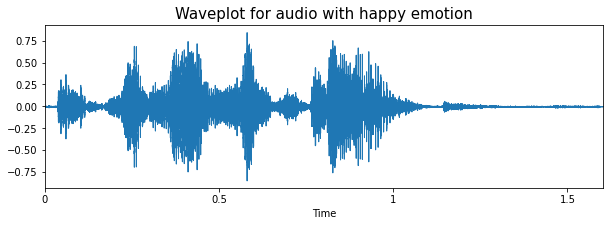

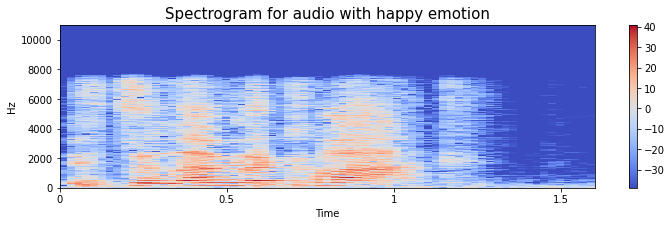

In [27]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [28]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

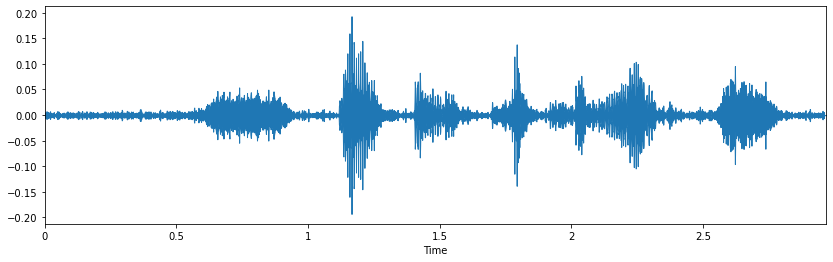

In [29]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

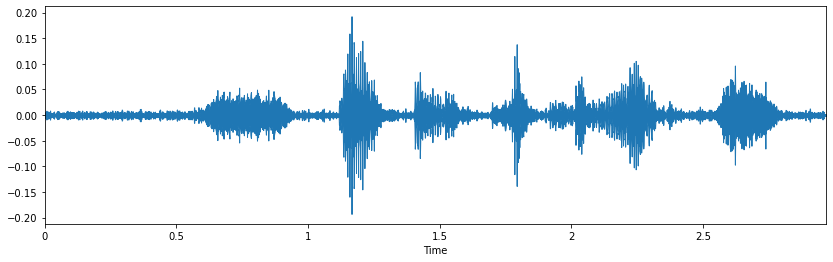

In [30]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

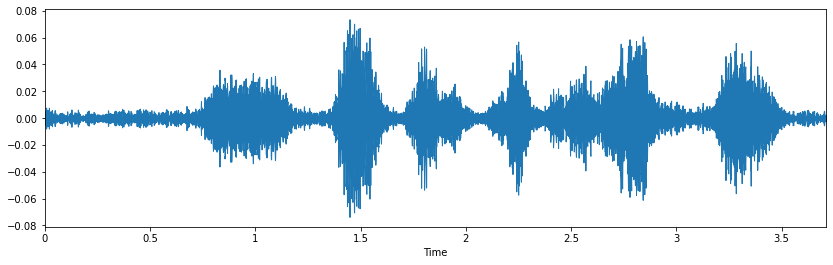

In [31]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

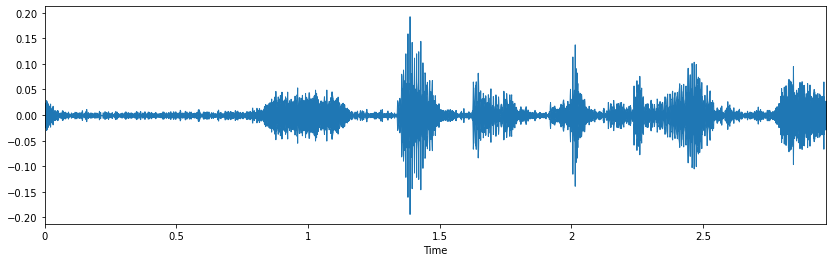

In [32]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

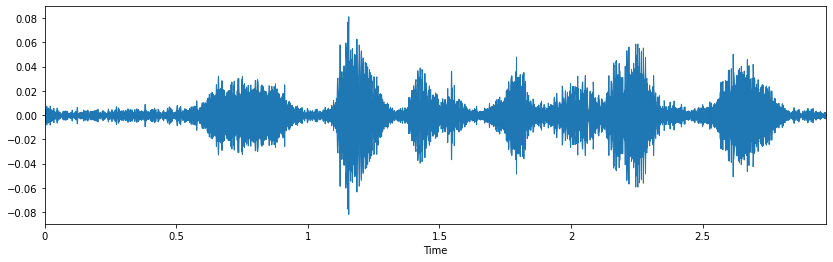

In [33]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [34]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [35]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

KeyboardInterrupt: ignored

In [36]:
len(X), len(Y), data_path.Path.shape

(300, 300, (7442,))

In [37]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.041822,0.701885,0.694987,0.674184,0.681488,0.655538,0.669576,0.723369,0.775617,0.758839,...,4.525296e-09,4.057204e-09,3.702153e-09,3.423555e-09,3.205379e-09,3.038743e-09,2.912927e-09,2.826292e-09,2.773027e-09,fear
1,0.044258,0.698343,0.704236,0.686844,0.681582,0.673429,0.647030,0.692095,0.754077,0.757187,...,2.338443e-06,2.427456e-06,2.365639e-06,2.339905e-06,2.315855e-06,2.365880e-06,2.444236e-06,2.384237e-06,2.285895e-06,fear
2,0.046597,0.664147,0.660974,0.692329,0.652879,0.636986,0.665721,0.608486,0.623761,0.696324,...,5.237963e-09,4.677730e-09,4.316259e-09,4.136889e-09,4.364221e-09,5.542060e-09,7.505412e-09,8.690351e-09,8.650972e-09,fear
3,0.149210,0.603091,0.663095,0.622262,0.634708,0.668332,0.637835,0.618390,0.615213,0.707195,...,1.073234e-08,9.725366e-09,8.977555e-09,8.394775e-09,7.938560e-09,7.589923e-09,7.325454e-09,7.143321e-09,7.030519e-09,disgust
4,0.198934,0.654020,0.702954,0.665931,0.692437,0.728633,0.665094,0.627422,0.627667,0.712670,...,1.267681e-04,1.308467e-04,1.242011e-04,1.266893e-04,1.275882e-04,1.314429e-04,1.308673e-04,1.247109e-04,1.317004e-04,disgust


In [38]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [39]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [40]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((225, 162), (225, 6), (75, 162), (75, 6))

In [41]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((225, 162), (225, 6), (75, 162), (75, 6))

In [42]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((225, 162, 1), (225, 6), (75, 162, 1), (75, 6))

In [43]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
262/262 [==============================] - 113s 428ms/step - loss: 1.6246 - accuracy: 0.3053 - val_loss: 1.5119 - val_accuracy: 0.3769 - lr: 0.0010
Epoch 2/50
262/262 [==============================] - 113s 430ms/step - loss: 1.5259 - accuracy: 0.3566 - val_loss: 1.4645 - val_accuracy: 0.3877 - lr: 0.0010
Epoch 3/50
262/262 [==============================] - 111s 425ms/step - loss: 1.4889 - accuracy: 0.3822 - val_loss: 1.4422 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 4/50
262/262 [==============================] - 112s 428ms/step - loss: 1.4725 - accuracy: 0.3866 - val_loss: 1.4266 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 5/50
262/262 [==============================] - 110s 422ms/step - loss: 1.4493 - accuracy: 0.3984 - val_loss: 1.3956 - val_accuracy: 0.4201 - lr: 0.0010
Epoch 6/50
262/262 [==============================] - 111s 425ms/step - loss: 1.4295 - accuracy: 0.4117 - val_loss: 1.4232 - val_accuracy: 0.4242 - lr: 0.0010
Epoch 7/50
262/262 [==========================

In [ ]:
import keras

In [ ]:
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

3/3 [==============================] - 1s 39ms/step - loss: 1.8231 - accuracy: 0.0933
Accuracy of our model on test data :  9.333333373069763 %


NameError: ignored

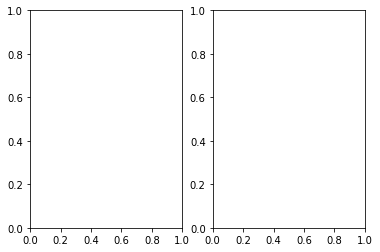

In [44]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [45]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

3/3 [==============================] - 0s 36ms/step


In [46]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,disgust,happy
2,happy,fear
3,disgust,happy
4,happy,neutral
5,disgust,sad
6,happy,happy
7,disgust,happy
8,happy,happy
9,disgust,happy


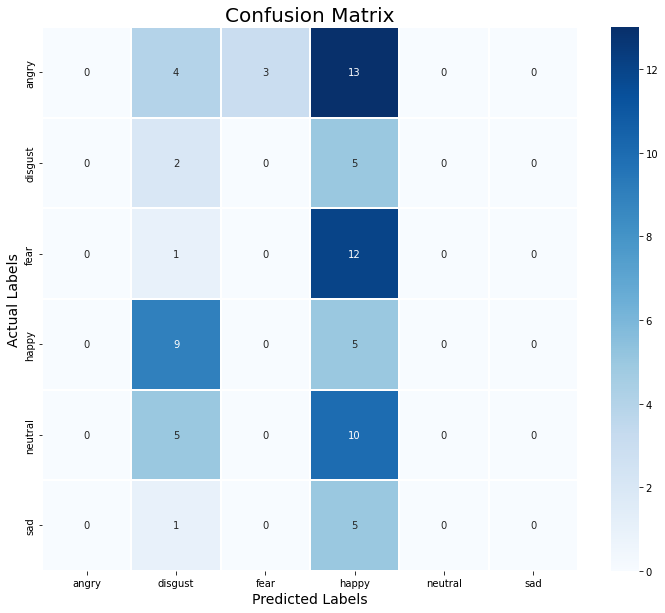

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        20
     disgust       0.09      0.29      0.14         7
        fear       0.00      0.00      0.00        13
       happy       0.10      0.36      0.16        14
     neutral       0.00      0.00      0.00        15
         sad       0.00      0.00      0.00         6

    accuracy                           0.09        75
   macro avg       0.03      0.11      0.05        75
weighted avg       0.03      0.09      0.04        75



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
